## Identify potential explanations (copy number, mutation) for A2 loss

**Input:**
- gene scores from running CERES
- gene copy number and gene mutations downloaded from the DepMap portal (19Q1)
- putative synthetic lethal pairs annotated among closest/all paralog pairs (results from nb 5)

**Output:** annotated version of putative synthetic lethal pairs annotated among closest/all paralog pairs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn2, venn3

%load_ext autoreload
%autoreload 1
from graphing_utils import *
%aimport graphing_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_gene_scores = get_local_data_path(['processed', 'depmap19Q1'], 'gene_scores_11_07_19.csv')
file_gene_copy_num = get_data_path(['depmap', '19Q1'], 'gene_cn.csv')
file_gene_mut = get_data_path(['depmap', '19Q1'], 'depmap_19Q1_mutation_calls_v2.csv')
file_results_closest = get_local_data_path(['processed', 'results'], 'closest_paralog_pairs_17_07_19.csv')
file_results_all = get_local_data_path(['processed', 'results'], 'all_paralog_pairs_17_07_19.csv')

# Outputs
file_closest_annotated = get_local_data_path(['processed', 'results'], 'closest_pairs_annotated_17_07_19.csv')
file_all_annotated = get_local_data_path(['processed', 'results'], 'all_pairs_annotated_17_07_19.csv')

cutoff_score = -0.47

### Data

In [5]:
all_scores = pd.read_csv(file_gene_scores, index_col=0).set_index('cell_line')
all_scores[:1]

,8036,55967,55153,25940,23224,116071,114803,1967,23014,29957,...,128344,55249,84304,5869,57818,5273,84952,11046,90594,400
cell_line,,,,,,,,,,,,,,,,,,,,,
ACH-000601,-0.117838,-0.083374,-0.75716,-0.07252,-0.012776,-0.119112,0.053607,-1.092377,-0.234541,-0.018627,...,-0.18303,-0.096821,-0.092369,0.004617,0.010656,-0.008256,0.003173,-0.062839,-0.016976,-0.154559


In [2]:
results_closest_pairs = pd.read_csv(file_results_closest)
print(results_closest_pairs[results_closest_pairs.SL].shape[0], '/', results_closest_pairs.shape[0])
results_closest_pairs[:1]

238 / 1819


,A1,A2,ttest_p,A2_expr_A1_NE,A2_expr_A1_E,ttest_p_correct,SL,percent_matched_in_paralog,WGD,either_in_complex,in_same_complex,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez
0,TEKT2,TEKT1,0.804338,0.038786,0.033592,0.934903,False,0.311628,WGD,False,False,ENSG00000092850,ENSG00000167858,27285,83659


In [28]:
results_all_pairs = pd.read_csv(file_results_all)
print(results_all_pairs[results_all_pairs.SL].shape[0], '/', results_all_pairs.shape[0])
print(results_all_pairs[results_all_pairs.SL].A1.nunique(), '/', results_all_pairs.A1.nunique())
results_all_pairs[:1]

375 / 6278
302 / 1829


,A1,A2,ttest_p,A2_expr_A1_NE,A2_expr_A1_E,ttest_p_correct,SL,percent_matched_in_paralog,WGD,either_in_complex,in_same_complex,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez
0,TEKT2,TEKT4,0.160877,0.064105,0.023072,0.520612,False,0.293023,WGD,False,False,ENSG00000092850,ENSG00000163060,27285,150483


### Closest pairs: Test for difference in A2 copy number among SLs

In [4]:
gene_cn_raw = pd.read_csv(file_gene_copy_num, index_col=0)

In [8]:
get_gene_id = lambda x: re.search('[\w-]+\s\((\w+)\)', x).group(1)
gene_cn = gene_cn_raw.rename(columns=get_gene_id)
# Reduce copy number data down to cell lines for which there are genes scores + gene expr (taken from prev. notebook)
gene_cn = gene_cn.loc[gene_cn.index.isin(all_scores.index) & 
                      ~gene_cn.index.isin(['ACH-001096','ACH-001151','ACH-001735','ACH-001736']),:]
print('Overlapping cell lines (gene score and copy number):', gene_cn.shape[0], '/', all_scores.shape[0]-4)
gene_cn[:1]

Overlapping cell lines (gene score and copy number): 554 / 554


,1,10,100,1000,10000,100008586,100009676,10001,10002,10003,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
ACH-000011,0.131139,-0.332231,0.18527,-0.322219,0.284791,-0.299359,-0.360381,-0.350737,0.196947,-0.375141,...,-0.304837,0.582631,-0.322219,-0.374689,-0.361973,0.189092,-0.272101,0.144758,-0.295499,0.144758


In [9]:
# Function to apply to each putative SL pair to find how many can be explained by difference in copy number
def test_diff_in_A2_copy_number(pair):
    df = pd.concat([gene_cn.loc[:, str(pair['A2_entrez'])], 
                    all_scores.loc[all_scores.index.isin(gene_cn.index), str(pair['A1_entrez'])]], axis=1, sort=True)
    df.columns = ['A2_cn', 'A1_score']
    df = df.dropna()
    cn_NE = df[df.A1_score > cutoff_score].A2_cn
    cn_E = df[df.A1_score <= cutoff_score].A2_cn
    ttest_p = stats.ttest_ind(cn_NE, cn_E).pvalue # 2-sided
    return pd.Series([pair.A1, pair.A2, ttest_p, cn_NE.mean(), cn_E.mean()], index=['A1', 'A2', 'ttest_p', 'A2_cn_A1_NE', 'A2_cn_A1_E'])

# Test for significant difference in copy number between essential / non-essential cell lines for SLs
# Only test the putative SLs
def test_copy_number_diff_for_pairs(pairs):
    cn_results = pairs[pairs.SL==True].apply(test_diff_in_A2_copy_number, axis=1)
    cn_results = cn_results.assign(p_correct = fdrcorrection(cn_results.ttest_p.values)[1])
    # A significant difference in copy number = corrected p val < 0.1 AND raw p < 0.05
    cn_results = cn_results.assign(signif = ((cn_results.p_correct < 0.1) & (cn_results.ttest_p < 0.05))
                                             & (cn_results.A2_cn_A1_NE > cn_results.A2_cn_A1_E))
    return cn_results

In [11]:
cn_results = test_copy_number_diff_for_pairs(results_closest_pairs)
print('SLs w/ significant copy number difference: %d/%d --> %.2f%%' % (cn_results[cn_results.signif].shape[0], 
                                cn_results.shape[0], cn_results[cn_results.signif].shape[0]/cn_results.shape[0] * 100))

SLs w/ significant copy number difference: 85/238 --> 35.71%


### Closest pairs: Test for difference in A2 mutation status among SLs

In [12]:
mutations_raw = pd.read_csv(file_gene_mut, low_memory=False)

In [13]:
mutations_raw[:1]

,X1,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,...,CCLE_WES_AC,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID
0,1,VPS13D,55187,37,1,12359347,12359347,+,Nonsense_Mutation,SNP,...,NaN,NaN,34:221,34:213,NaN,NaN,NaN,NaN,damaging,ACH-000001


In [14]:
mutations = mutations_raw.rename(columns={'Entrez_Gene_Id':'entrez_id', 'Hugo_Symbol':'symbol'})
mutations = mutations[['entrez_id', 'symbol', 'Variant_Classification', 'Variant_Type', 'DepMap_ID']]
# Reduce mutation data down to cell lines for which there are genes scores + gene expr (taken from prev. notebook)
mutations = mutations[mutations.DepMap_ID.isin(all_scores.index) & 
                      ~mutations.DepMap_ID.isin(['ACH-001096','ACH-001151','ACH-001735','ACH-001736'])].reset_index(drop=True)
print('Overlapping cell lines (fitness score & mutations): ', mutations.DepMap_ID.nunique(),'/', all_scores.shape[0]-4)
mutations[:1]

Overlapping cell lines (fitness score & mutations):  551 / 554


,entrez_id,symbol,Variant_Classification,Variant_Type,DepMap_ID
0,388591,RNF207,Missense_Mutation,SNP,ACH-000004


In [15]:
mutations.Variant_Classification.unique()

array(['Missense_Mutation', 'Silent', 'Frame_Shift_Del', 'Splice_Site',
       'Frame_Shift_Ins', 'Nonsense_Mutation', 'De_novo_Start_OutOfFrame',
       'In_Frame_Del', 'In_Frame_Ins', 'Start_Codon_SNP',
       'Nonstop_Mutation', 'Stop_Codon_Del', 'Start_Codon_Ins',
       'Stop_Codon_Ins', nan, 'Intron', 'Start_Codon_Del', "5'Flank",
       'IGR', "3'UTR", "5'UTR"], dtype=object)

In [17]:
def test_A2_mutation(pair):
    mutation_types = ['Nonsense_Mutation']
    A2_mut = mutations[(mutations.entrez_id==pair.A2_entrez) & 
                       (mutations.Variant_Classification.isin(mutation_types))]
    df = pd.DataFrame(all_scores.loc[all_scores.index.isin(gene_cn.index), str(pair.A1_entrez)])
    df = df.assign(A1_E = df[str(pair.A1_entrez)] <= cutoff_score)
    df = df.assign(mutation = df.index.isin(A2_mut.DepMap_ID))
    ctab = pd.crosstab(df.A1_E, df.mutation, dropna=False)
    if ctab.shape[1] != 2: # return null if A2 never (or always) has a mutation of the given types
        return pd.Series([pair.A1, pair.A2, float('nan'), float('nan')], index=['A1', 'A2', 'OR', 'pval'])
    fet = stats.fisher_exact(ctab)
    return pd.Series([pair.A1, pair.A2, fet[0], fet[1]], index=['A1', 'A2', 'OR', 'pval'])

# Test for significant difference in mutations between essential / non-essential cell lines for SLs
# Only test the putative SLs
def test_mutation_for_pairs(pairs):
    mut_results = pairs[pairs.SL==True].apply(test_A2_mutation, axis=1)
    # Drop NAs => gene pairs where A2 is never mutated in the available data
    mut_results = mut_results.dropna()
    # Looking for OR > 1 ===> enrichment of nonsense mutations A2 for A1 essential
    mut_results = mut_results.assign(p_correct = fdrcorrection(mut_results.pval.values)[1])
    mut_results = mut_results.assign(signif = ((mut_results.p_correct < 0.1) & (mut_results.OR > 1)))
    return mut_results

In [19]:
mut_results = test_mutation_for_pairs(results_closest_pairs)
print('SLs w/ significant mutation difference: %d/%d --> %.2f%%' % (mut_results[mut_results.signif].shape[0], 
                                    mut_results.shape[0], mut_results[mut_results.signif].shape[0]/mut_results.shape[0]*100))
# OR=inf means there is never a mutation when A1 is not essential
mut_results[mut_results.signif == True]

SLs w/ significant mutation difference: 3/92 --> 3.26%


,A1,A2,OR,pval,p_correct,signif
1017,STAG1,STAG2,inf,0.001652,0.050650,True
1304,ARID1B,ARID1A,10.058824,0.000213,0.010248,True
1454,SMARCA2,SMARCA4,21.200000,0.000223,0.010248,True


### Closest pairs: overview of reasons for A2 loss

In [20]:
# Add column for copy number driven
annotated_results = pd.merge(results_closest_pairs, cn_results[cn_results.signif][['A1','A2']], 
                             indicator='copy_number_driven', on=['A1', 'A2'], how='left')
annotated_results.copy_number_driven = annotated_results.copy_number_driven == 'both'

# Add column for mutation driven to the original results df
annotated_results = pd.merge(annotated_results, mut_results[mut_results.signif][['A1','A2']], 
                             indicator='nonsense_mutation_driven', on=['A1', 'A2'], how='left')
annotated_results.nonsense_mutation_driven = annotated_results.nonsense_mutation_driven == 'both'

assert(sum(annotated_results.copy_number_driven) == cn_results[cn_results.signif].shape[0])
assert(sum(annotated_results.nonsense_mutation_driven) == mut_results[mut_results.signif].shape[0])
annotated_results.to_csv(file_closest_annotated, index=0)
annotated_results[:1]

,A1,A2,ttest_p,A2_expr_A1_NE,A2_expr_A1_E,ttest_p_correct,SL,percent_matched_in_paralog,WGD,either_in_complex,in_same_complex,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,copy_number_driven,nonsense_mutation_driven
0,TEKT2,TEKT1,0.804338,0.038786,0.033592,0.934903,False,0.311628,WGD,False,False,ENSG00000092850,ENSG00000167858,27285,83659,False,False


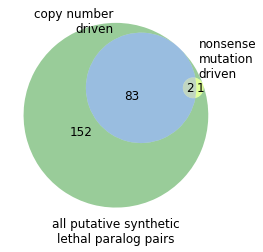

In [27]:
annotated_results = pd.read_csv(file_closest_annotated)
df = annotated_results[annotated_results.SL==True]
set1 = set(df.apply(lambda x: (x.A1, x.A2), axis=1).values)
set2 = set(df[df.copy_number_driven==True].apply(lambda x: (x.A1, x.A2), axis=1).values)
set3 = set(df[df.nonsense_mutation_driven==True].apply(lambda x: (x.A1, x.A2), axis=1).values)

venn = venn3([set2, set3, set1], set_colors=('blue', 'yellow', 'green'), 
             set_labels= ('copy number\ndriven', 'nonsense\nmutation\ndriven', 'all putative synthetic\nlethal paralog pairs'))
for text in venn.set_labels: text.set_fontsize(mpl.rcParams['axes.labelsize'])
for text in venn.subset_labels:
    if text != None: text.set_fontsize(mpl.rcParams['axes.labelsize'])

#plt.savefig('../figures/venn.svg',  bbox_inches='tight', dpi=300)

### All pairs: Test for difference in A2 copy number among SLs

In [29]:
cn_results2 = test_copy_number_diff_for_pairs(results_all_pairs)
print('SLs w/ significant copy number difference: %d/%d --> %.2f%%' % (cn_results2[cn_results2.signif].shape[0], 
                                    cn_results2.shape[0], cn_results2[cn_results2.signif].shape[0]/cn_results2.shape[0] * 100))

SLs w/ significant copy number difference: 110/375 --> 29.33%


### All pairs: Test for difference in A2 nonsense mutation status among SLs

In [30]:
mut_results2 = test_mutation_for_pairs(results_all_pairs)
print('SLs w/ significant mutation difference: %d/%d --> %.2f%%' % (mut_results2[mut_results2.signif].shape[0], 
                                mut_results2.shape[0], mut_results2[mut_results2.signif].shape[0]/mut_results2.shape[0] * 100))
# OR=inf means there is never a mutation when A1 is not essential
mut_results2[mut_results2.signif == True]

SLs w/ significant mutation difference: 3/149 --> 2.01%


,A1,A2,OR,pval,p_correct,signif
4546,STAG1,STAG2,inf,0.001652,0.082031,True
5448,ARID1B,ARID1A,10.058824,0.000213,0.016597,True
5783,SMARCA2,SMARCA4,21.200000,0.000223,0.016597,True


### All pairs: overview of reasons for A2 loss

In [31]:
# Add column for copy number driven
annotated_results2 = pd.merge(results_all_pairs, cn_results2[cn_results2.signif][['A1','A2']], 
                             indicator='copy_number_driven', on=['A1', 'A2'], how='left')
annotated_results2.copy_number_driven = annotated_results2.copy_number_driven == 'both'

# Add column for mutation driven to the original results df
annotated_results2 = pd.merge(annotated_results2, mut_results2[mut_results2.signif][['A1','A2']], 
                             indicator='nonsense_mutation_driven', on=['A1', 'A2'], how='left')
annotated_results2.nonsense_mutation_driven = annotated_results2.nonsense_mutation_driven == 'both'

assert(sum(annotated_results2.copy_number_driven) == cn_results2[cn_results2.signif].shape[0])
assert(sum(annotated_results2.nonsense_mutation_driven) == mut_results2[mut_results2.signif].shape[0])
annotated_results2.to_csv(file_all_annotated, index=0)
annotated_results2[:1]

,A1,A2,ttest_p,A2_expr_A1_NE,A2_expr_A1_E,ttest_p_correct,SL,percent_matched_in_paralog,WGD,either_in_complex,in_same_complex,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,copy_number_driven,nonsense_mutation_driven
0,TEKT2,TEKT4,0.160877,0.064105,0.023072,0.520612,False,0.293023,WGD,False,False,ENSG00000092850,ENSG00000163060,27285,150483,False,False


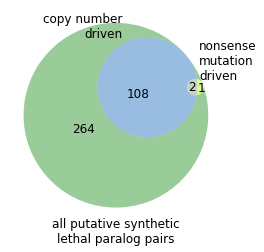

In [33]:
annotated_results2 = pd.read_csv(file_all_annotated)
df = annotated_results2[annotated_results2.SL==True]
set1 = set(df.apply(lambda x: (x.A1, x.A2), axis=1).values)
set2 = set(df[df.copy_number_driven==True].apply(lambda x: (x.A1, x.A2), axis=1).values)
set3 = set(df[df.nonsense_mutation_driven==True].apply(lambda x: (x.A1, x.A2), axis=1).values)

venn = venn3([set2, set3, set1], set_colors=('blue', 'yellow', 'green'), 
             set_labels= ('copy number\ndriven', 'nonsense\nmutation\ndriven', 'all putative synthetic\nlethal paralog pairs'))
for text in venn.set_labels: text.set_fontsize(mpl.rcParams['axes.labelsize'])
for text in venn.subset_labels:
    if text != None: text.set_fontsize(mpl.rcParams['axes.labelsize'])

#plt.savefig('../figures/venn2.svg',  bbox_inches='tight', dpi=300)

### Export pairs to supplemental tables
* the raw t-test and FDR corrected p-values for differential expression, 
* their percentage protein sequence identity, 
* their mode of duplication, 
* whether either paralog is a member of a protein complex, 
* whether both paralogs are members of the same protein complex.
* whether the  SL effect is driven by copy number variation and/or nonsense mutations

In [34]:
def export_supp_table(results, file_name):
    df = results[results.SL == True]
    df = df[['A1', 'A2', 'A1_ensembl', 'A2_ensembl', 'ttest_p', 'ttest_p_correct', 'percent_matched_in_paralog', 
             'WGD', 'either_in_complex', 'in_same_complex', 'copy_number_driven', 'nonsense_mutation_driven']]
    df = df.rename(columns={'ttest_p':'ttest_pvalue', 'ttest_p_correct':'corrected_pvalue',
                            'percent_matched_in_paralog': 'percent_sequence_identity', 'WGD':'duplication_mode'})
    print('copy # driven:', df[df.copy_number_driven==True].shape[0], '/', df.shape[0])
    print('nonsense mutation driven:', df[df.nonsense_mutation_driven==True].shape[0], '/', df.shape[0])
    display(df[:1])
    df.to_csv(get_local_data_path(['supplemental_files'], file_name), index=0)

In [35]:
annotated_results = pd.read_csv(file_closest_annotated)
export_supp_table(annotated_results, 'Table_S4.csv')

copy # driven: 85 / 238
nonsense mutation driven: 3 / 238


,A1,A2,A1_ensembl,A2_ensembl,ttest_pvalue,corrected_pvalue,percent_sequence_identity,duplication_mode,either_in_complex,in_same_complex,copy_number_driven,nonsense_mutation_driven
9,MIB1,MIB2,ENSG00000101752,ENSG00000197530,0.008902,0.058037,0.392644,SSD,False,False,False,False


In [36]:
annotated_results = pd.read_csv(file_all_annotated)
export_supp_table(annotated_results, 'Table_S5.csv')

copy # driven: 110 / 375
nonsense mutation driven: 3 / 375


,A1,A2,A1_ensembl,A2_ensembl,ttest_pvalue,corrected_pvalue,percent_sequence_identity,duplication_mode,either_in_complex,in_same_complex,copy_number_driven,nonsense_mutation_driven
6,CPAMD8,CD109,ENSG00000160111,ENSG00000156535,0.004233,0.05379,0.220497,SSD,False,False,False,False


In [37]:
def export_extended_supp_table(results, file_name):
    df = results[['A1', 'A2', 'A1_ensembl', 'A2_ensembl', 'SL', 'ttest_p', 'ttest_p_correct', 'percent_matched_in_paralog', 
             'WGD', 'either_in_complex', 'in_same_complex']]
    df = df.rename(columns={'ttest_p':'ttest_pvalue', 'ttest_p_correct':'corrected_pvalue',
                            'percent_matched_in_paralog': 'percent_sequence_identity', 'WGD':'duplication_mode'})
    df = df.sort_values(['A1','A2']).reset_index(drop=True)
    print('# SL:', df[df.SL==True].shape[0], '/', df.shape[0])
    display(df[:1])
    df.to_csv(get_local_data_path(['supplemental_files'], file_name), index=0)

In [74]:
# annotated_results = pd.read_csv(file_closest_annotated)
# export_extended_supp_table(annotated_results, 'Table_S4_extended.csv')

# SL: 238 / 1819


,A1,A2,A1_ensembl,A2_ensembl,SL,ttest_pvalue,corrected_pvalue,percent_sequence_identity,duplication_mode,either_in_complex,in_same_complex
0,AAK1,BMP2K,ENSG00000115977,ENSG00000138756,False,0.90543,0.965403,0.413111,SSD,False,False


In [75]:
# annotated_results = pd.read_csv(file_all_annotated)
# export_extended_supp_table(annotated_results, 'Table_S5_extended.csv')

# SL: 375 / 6278


,A1,A2,A1_ensembl,A2_ensembl,SL,ttest_pvalue,corrected_pvalue,percent_sequence_identity,duplication_mode,either_in_complex,in_same_complex
0,AAK1,BMP2K,ENSG00000115977,ENSG00000138756,False,0.90543,0.966716,0.413111,SSD,False,False
